In [1]:
using AutoRisk
using AutoViz
using PGFPlots
using Colors

In [2]:
d = JLD.load("../../data/bayesnets/base_test.jld") 
base_bn = d["bn"]
base_discs = d["discs"]

d = JLD.load("../../data/bayesnets/base_test.jld") 
prop_bn = d["bn"]
prop_discs = d["discs"];

In [3]:
# build the generator
base_sampler = AssignmentSampler(base_discs)
prop_sampler = AssignmentSampler(prop_discs)
num_veh_per_lane = 20
min_p = get_passive_behavior_params(err_p_a_to_i = .01)
max_p = get_aggressive_behavior_params(err_p_a_to_i = .01)
behgen = CorrelatedBehaviorGenerator(min_p, max_p)
gen = BayesNetLaneGenerator(base_bn, base_sampler, prop_bn, prop_sampler, num_veh_per_lane, behgen);

In [4]:
num_lanes = 3
roadway = gen_straight_roadway(num_lanes, 100000.)
scene = Scene(num_veh_per_lane * num_lanes)
models = Dict{Int,DriverModel}()
rand!(gen, roadway, scene, models, 7);

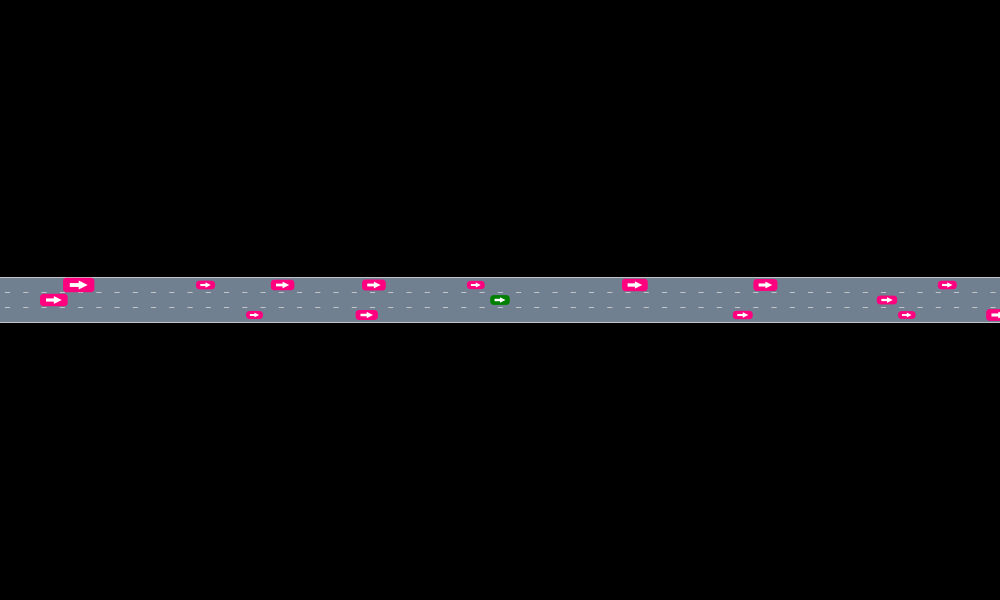

In [5]:
carcolors = Dict{Int,Colorant}()
carcolors[39] = colorant"green"
render(scene, roadway, cam=CarFollowCamera{Int}(39, 5.), car_colors=carcolors)

In [6]:
# scene feature extractors
function get_static_features(scene::Scene, roadway::Roadway)
    # feature containers, censors
    timegaps = zeros(Float64, length(scene))
    timegap_censor_hi = 15.
    ttcs = zeros(Float64, length(scene))
    ttc_censor_hi = 35.
    velocities = zeros(Float64, length(scene))
    vel_censor_hi = 35.
    distance_fores = zeros(Float64, length(scene))
    distance_fore_censor_hi = 60.
    
    for veh_idx in 1:length(scene)
        ego_veh = scene.entities[veh_idx]        
        neigh = get_neighbor_fore_along_lane(scene, veh_idx, roadway)
        
        # if the fore vehicle does not exist then set as censor high
        if neigh.ind == 0
            timegaps[veh_idx] = timegap_censor_hi
            distance_fores[veh_idx] = distance_fore_censor_hi
            ttcs[veh_idx] = ttc_censor_hi
            velocities[veh_idx] = vel_censor_hi
        else
            # get both vehicles 
            rear_veh = scene.entities[veh_idx]
            fore_veh = scene.entities[neigh.ind]
            
            # want the time for the rear vehicle's front to reach the fore vehicle's back
            v = rear_veh.state.v
            
            # first term is distance between centers
            # second moves from fore vehicle center to back bumper
            # third moves from rear vehicle center to front bumper
            Δs = (fore_veh.state.posF.s - rear_veh.state.posF.s) - (fore_veh.def.length / 2) - (rear_veh.def.length / 2)
            timegaps[veh_idx] = min(Δs / v, timegap_censor_hi)
            
            # distance fore
            distance_fores[veh_idx] = min(Δs, distance_fore_censor_hi)
            
            Δv = fore_veh.state.v - rear_veh.state.v
            
            # relative velocity
            velocities[veh_idx] = Δv
            
            # time to collision
            if Δv < 0.
                ttcs[veh_idx] = min(max(-1 * Δs / Δv, 0.), ttc_censor_hi)
            else # this means fore vehicle moving away too quickly
                ttcs[veh_idx] = ttc_censor_hi
            end
            
        end
    end
    return timegaps, ttcs, velocities, distance_fores
end

get_static_features (generic function with 1 method)

In [7]:
function get_behavior_features(models::Dict{Int, DriverModel})
    is_attentives = zeros(Float64, length(models))
    aggressivenesses = zeros(Float64, length(models))
    for (idx, (id, m)) in enumerate(models)
        is_attentives[idx] = m.is_attentive ? 1 : 0 
        politeness = m.driver.mlane.politeness
        aggressivenesses[idx] = infer_correlated_aggressiveness(politeness)
    end
    return is_attentives, aggressivenesses
end

get_behavior_features (generic function with 1 method)

In [8]:
num_scenes, num_veh = 100, num_veh_per_lane
emergent = Dict{String, Array{Float64}}()
total_num_veh = num_scenes * num_veh * num_lanes
emergent["timegap"] = zeros(Float64, total_num_veh)
emergent["ttc"] = zeros(Float64, total_num_veh)
emergent["velocity"] = zeros(Float64, total_num_veh)
emergent["distance_fore"] = zeros(Float64, total_num_veh)
emergent["is_attentive"] = zeros(Float64, total_num_veh)
emergent["aggressiveness"] = zeros(Float64, total_num_veh)
collect_prop_only = true
for scene_idx in 1:num_scenes
    rand!(gen, roadway, scene, models, scene_idx)
    timegaps, ttcs, velocities, distance_fores = get_static_features(scene, roadway)
    is_attentives, aggressivenesses = get_behavior_features(models)
    s = (scene_idx - 1) * num_lanes * num_veh
    e = s + num_lanes * num_veh
    emergent["timegap"][s+1:e] = timegaps
    emergent["ttc"][s+1:e] = ttcs
    emergent["velocity"][s+1:e] = velocities
    emergent["distance_fore"][s+1:e] = distance_fores
    emergent["is_attentive"][s+1:e] = is_attentives
    emergent["aggressiveness"][s+1:e] = aggressivenesses
end

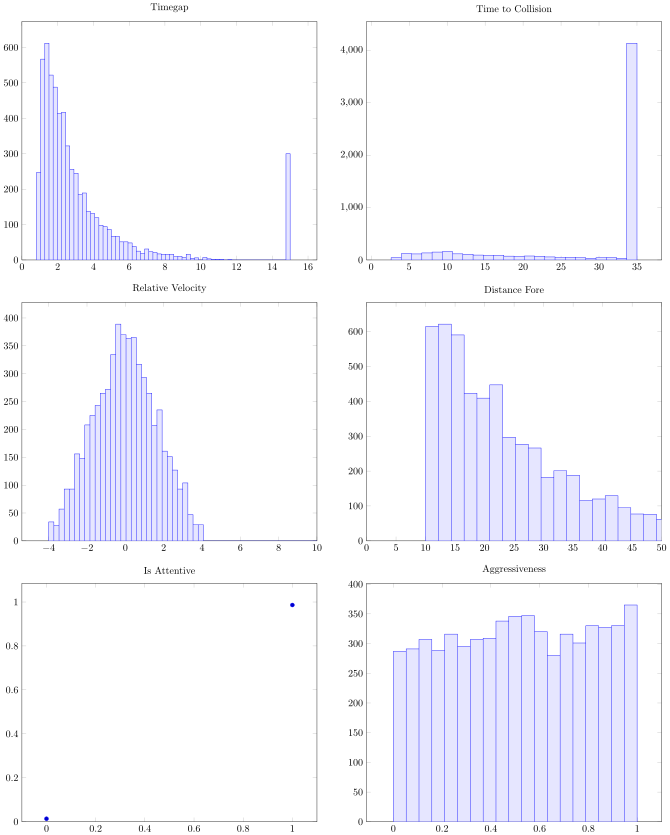

In [9]:
# analyze emergent behavior
g = GroupPlot(2, 3, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
nbins = 100
timegap_axis = Axis(Plots.Histogram(emergent["timegap"], bins=nbins), 
                    ymin=0, 
                    xmin=0,
                    width="12cm",
                    height="10cm",
                    title="Timegap")
push!(g, timegap_axis)
ttc_axis = Axis(Plots.Histogram(emergent["ttc"], bins=nbins), 
                    ymin=0, 
                    width="12cm",
                    height="10cm",
                    title="Time to Collision")
push!(g, ttc_axis)
velocity_axis = Axis(Plots.Histogram(emergent["velocity"], bins=nbins), 
                    ymin=0,
                    xmax=10,
                    width="12cm",
                    height="10cm",
                    title="Relative Velocity")
push!(g, velocity_axis)
distance_fore_axis = Axis(Plots.Histogram(emergent["distance_fore"], bins=nbins), 
                    ymin=0,  
                    xmin=0,
                    xmax=50,
                    width="12cm",
                    height="10cm",
                    title="Distance Fore")
push!(g, distance_fore_axis)
p_attentive = sum(emergent["is_attentive"]) / length(emergent["is_attentive"])
is_attentive_axis = Axis(Plots.Linear([0.,1.], [1 - p_attentive, p_attentive], onlyMarks=true), 
                    ymin=0,  
                    width="12cm",
                    height="10cm",
                    title="Is Attentive")
push!(g, is_attentive_axis)
aggressiveness_axis = Axis(Plots.Histogram(emergent["aggressiveness"], bins=nbins), 
                    ymin=0,  
                    xmax=1.1,
                    width="12cm",
                    height="10cm",
                    title="Aggressiveness")
push!(g, aggressiveness_axis)
g

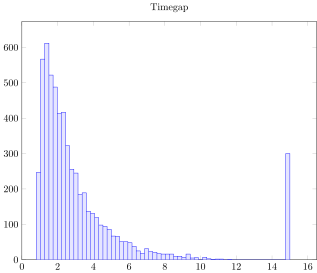

In [10]:
timegap_axis = Axis(Plots.Histogram(emergent["timegap"], bins=nbins), 
                    ymin=0, 
                    xmin=0,
                    width="12cm",
                    height="10cm",
                    title="Timegap")

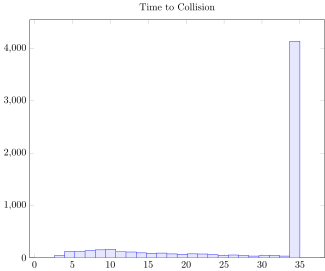

In [11]:
ttc_axis = Axis(Plots.Histogram(emergent["ttc"], bins=nbins), 
                    ymin=0, 
                    width="12cm",
                    height="10cm",
                    title="Time to Collision")

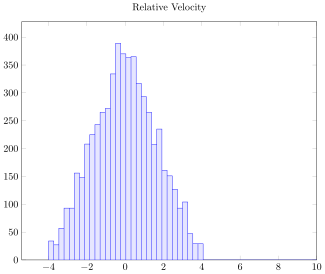

In [12]:
velocity_axis = Axis(Plots.Histogram(emergent["velocity"], bins=nbins), 
                    ymin=0,
                    xmax=10,
                    width="12cm",
                    height="10cm",
                    title="Relative Velocity")

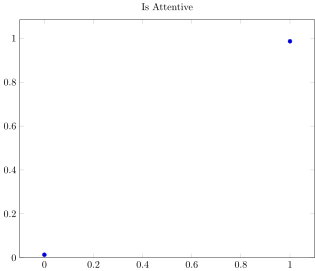

In [13]:
p_attentive = sum(emergent["is_attentive"]) / length(emergent["is_attentive"])
is_attentive_axis = Axis(Plots.Linear([0.,1.], [1 - p_attentive, p_attentive], onlyMarks=true), 
                    ymin=0,  
                    width="12cm",
                    height="10cm",
                    title="Is Attentive")

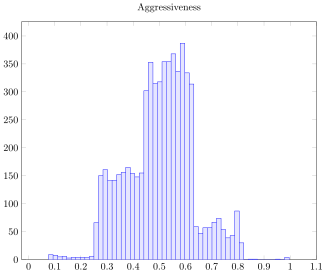

In [14]:
aggressiveness_axis = Axis(Plots.Histogram(emergent["aggressiveness"], bins=nbins), 
                    ymin=0,  
                    xmax=1.1,
                    width="12cm",
                    height="10cm",
                    title="Aggressiveness")